## TIW variance calculation

This notebook calculates the variance over a given time-period of 12deg longitude high-pass filtered SSH variability from daily output.

Minimal version for checking computation efficiency

In [3]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from scipy import signal

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [4]:
# Load workers:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36009/status,
Dashboard: /proxy/36009/status,Workers: 8
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36667,Workers: 8
Dashboard: /proxy/36009/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.1:34331,Total threads: 1
Dashboard: /proxy/44127/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41461,


In [5]:
session = cc.database.create_session()
exp = '01deg_jra55v140_iaf'

In [8]:
%%time
# longitude filter width:
ln_hp_filt = 12.0

# Region definition:
xr = -170.,-100.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = -2.,10.
timer = '2009-01-01','2019-01-01'

# Get data obj:
ssh = cc.querying.getvar(exp, 'sea_level',session, frequency='1 daily',start_time=timer[0],end_time=timer[1])
ssh = ssh.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))

CPU times: user 1.16 s, sys: 163 ms, total: 1.32 s
Wall time: 4.86 s


In [9]:
%%time
# Do high-pass filtering:
ssh_hp = (ssh-ssh.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 24s, sys: 6.41 s, total: 2min 31s
Wall time: 2min 46s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'sea_level' (yt_ocean: 121, xt_ocean: 820)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -175.9 -175.8 -175.7 ... -94.25 -94.15 -94.05
  * yt_ocean  (yt_ocean) float64 -1.95 -1.85 -1.75 -1.65 ... 9.802 9.9 9.999

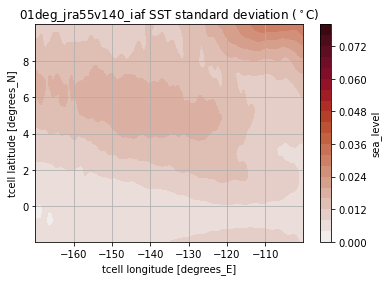

In [11]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
ssh_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
plt.gca().set_title(exp + ' SST standard deviation ($^\circ$C)')
plt.gca().grid()